In [1]:
cd ../../../

/private/home/ronghanghu/workspace/mmf_nr


In [2]:
import os
import numpy as np
import torch
import torchvision
import argparse
import omegaconf
import matplotlib.pyplot as plt

from mmf.utils.env import setup_imports
from mmf.utils.configuration import Configuration
from mmf.utils.build import build_config, build_model
from mmf.common.sample import SampleList, Sample


def get_config_from_opts(opts):
    setup_imports()

    args = argparse.Namespace(config_override=None)
    args.opts = opts

    configuration = Configuration(args)
    config = build_config(configuration)
    return config


def load_model(config, device, ckpt_file=None):
    attributes = config.model_config[config.model]
    # Easy way to point to config for other model
    if isinstance(attributes, str):
        attributes = config.model_config[attributes]

    with omegaconf.open_dict(attributes):
        attributes.model = config.model

    model = build_model(attributes)
    model = model.to(device)
    model.eval()

    if ckpt_file is not None:
        state_dict = torch.load(ckpt_file, map_location=device)["model"]
        model.load_state_dict(state_dict)

    return model


def build_sample_list(img_0, R_0, T_0, R_1, T_1, image_transform):
    sample = Sample()
    sample.orig_img_0 = torch.tensor(img_0)
    sample.trans_img_0 = image_transform(sample.orig_img_0.permute((2, 0, 1)))
    sample.R_0 = torch.tensor(R_0)
    sample.T_0 = torch.tensor(T_0)
    sample.R_1 = torch.tensor(R_1)
    sample.T_1 = torch.tensor(T_1)
    sample_list = SampleList([sample]).to(device)
    return sample_list

In [3]:
exp_name = "defaults"

opts = [
    f"config=projects/neural_rendering/configs/replica/{exp_name}.yaml",
    f"datasets=replica",
    f"model=mesh_renderer",
    f"training.batch_size=1",
    f"model_config.mesh_renderer.return_rendering_results_only=True",
]

device = torch.device("cuda:1")
torch.cuda.set_device(device)

ckpt_file = f"./save/replica/{exp_name}/best.ckpt"
if not os.path.exists(ckpt_file):
    ckpt_file = ckpt_file.replace("best.ckpt", "current.ckpt")
assert os.path.exists(ckpt_file)

config = get_config_from_opts(opts)
model = load_model(config, device, ckpt_file)

/private/home/ronghanghu/workspace/mmf_nr/mmf/models/base_model.py:96: UserWarning: No losses are defined in model configuration. You are expected to return loss in your return dict from forward.
  "No losses are defined in model configuration. You are expected "


In [4]:
saved_data_file = "/checkpoint/ronghanghu/neural_rendering_datasets/replica/test/data/scene_0000_sample_00000000.npz"
saved_results_file = './save/visualization/defaults/test/scene_0000_sample_00000000_outputs.npz'

d = np.load(saved_data_file)
data = dict(d)
d.close()
d = np.load(saved_results_file)
data.update(d)
d.close()

# normalize with ResNet-50 preprocessing
image_transform = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


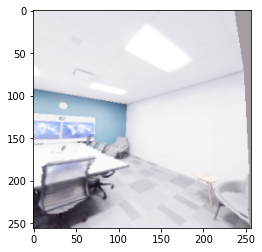

In [5]:
sample_list = build_sample_list(
    img_0=data['orig_img_0'],
    R_0=data["camera_Rs"][0],
    T_0=data["camera_Ts"][0],
    R_1=data["camera_Rs"][1],
    T_1=data["camera_Ts"][1],
    image_transform=image_transform
).to(device)

with torch.no_grad():
    rendering_results = model.forward(sample_list)

rgba_out = rendering_results['rgba_out_rec_list'][1][0, ..., :3].cpu().numpy()
plt.imshow(rgba_out)